In [8]:
from user_ops import ft_pool
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import math
import pickle
import json

import os
import sys
sys.path.append(os.path.join('..', '..', 'keras_frac'))
from fractional_maxpooling import FractionalPooling2D
import resnet

%matplotlib inline

init = "he_uniform"

In [ ]:
class max_pool_net:
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='r2c2elu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
    
    def train(self, batch_size, epochs, datagen=None, train_data=None, callbacks=None):
        if datagen is None and train_data is None:
            print('neither data or generator was passed')
        elif datagen is None and train_data is not None:
            print('training on array data, network type:', type(self).__name__)
            self.history = self.model.fit(x = train_data[0], y = train_data[1], validation_data=train_data[2:], batch_size=batch_size, epochs=epochs, callbacks=callbacks)
        else:
            print('training on datagen data, network type:', type(self).__name__)
            self.history = self.model.fit_generator(datagen, validation_data=train_data[2:], batch_size=batch_size, epochs=epochs, callbacks=callbacks)
        self.weights = self.model.get_weights()
    
    def restart_session(self):
        keras.backend.clear_session()
        
    def get_history(self):
        return self.history
    
    def get_weights(self):
        return self.weights
    
    def load_weights(self):
        self.model.load_weights(self.weights)

        
class frac_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        ratio = 1.35 # 1.33 blocks=3
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(FractionalPooling2D(pool_ratio=(1, ratio, ratio, 1),pseudo_random = True, overlap=False))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
    
    
class ft_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        strides=(math.sqrt(2), math.sqrt(2))
        pool_size=(math.sqrt(2)*2, math.sqrt(2)*2)
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.Lambda(lambda x: ft_pool(x, strides, pool_size)))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
        
class avg_pool_net(max_pool_net):
    def __init__(self, opt, batch_input_shape, classes, k_size=(3,3), filters=2, blocks=2):
        pool_size=2
        self.model = keras.models.Sequential()
        self.model.add(keras.layers.InputLayer(batch_input_shape=batch_input_shape))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.Conv2D(filters, k_size, activation='relu', padding='same', kernel_initializer=init))
        self.model.add(keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), strides=(2,2), padding='same'))
        for i in range(2, blocks+1):
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.Conv2D(filters*i, k_size, activation='relu', padding='same', kernel_initializer=init))
            self.model.add(keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), strides=(2,2), padding='same'))
        self.model.add(keras.layers.Flatten())
        self.model.add(keras.layers.Dense(classes, activation='softmax'))
        self.model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())

In [5]:
EPOCHS = 30
BATCH_SIZE = 100
iter = 1

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [6]:
ft_net_h = []
path = os.path.join('results', 'mine_with_div')
for _ in range(iter):
    ft_net = ft_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
    ft_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1)])
    ft_net_h.append([ft_net.get_history().history['accuracy'], ft_net.get_history().history['val_accuracy']])
    ft_net.restart_session()
with open(os.path.join(path,'ft_net_h.pkl'), 'wb') as f:
    pickle.dump(ft_net_h, f)
'''
avg_net_h = []
for _ in range(iter):
    avg_net = avg_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
    avg_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1)])
    avg_net_h.append([avg_net.get_history().history['accuracy'], avg_net.get_history().history['val_accuracy']])
    avg_net.restart_session()
with open(os.path.join(path,'avg_net_h.pkl'), 'wb') as f:
    pickle.dump(avg_net_h, f)

max_net_h = []
for _ in range(iter):
    max_net = max_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
    max_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1)])
    max_net_h.append([max_net.get_history().history['accuracy'], max_net.get_history().history['val_accuracy']])
    max_net.restart_session()
with open(os.path.join(path,'max_net_h.pkl')) as f:
    pickle.dump(max_net_h, f)

frac_net_h = []
for _ in range(iter):
    frac_net = frac_pool_net(keras.optimizers.Adadelta(), (BATCH_SIZE,) + x_train.shape[1:], y_train.shape[1], blocks=2)
    frac_net.train(BATCH_SIZE, EPOCHS, train_data=(x_train, y_train, x_test, y_test), callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, verbose=1)])
    frac_net_h.append([frac_net.get_history().history['accuracy'], frac_net.get_history().history['val_accuracy']])
    frac_net.restart_session()
with open(os.path.join(path,'frac_net_h.pkl'), 'wb') as f:
    pickle.dump(frac_net_h, f)
'''

NameError: name 'ft_pool_net' is not defined

In [ ]:
# baseline best 2x max pool = 53.19%

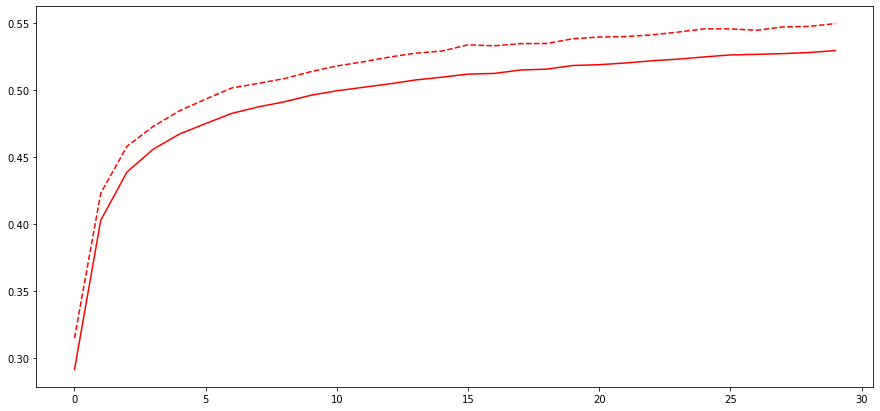

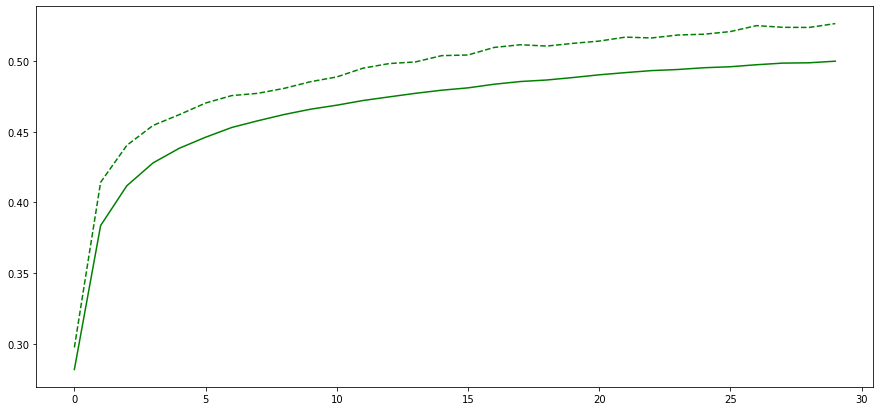

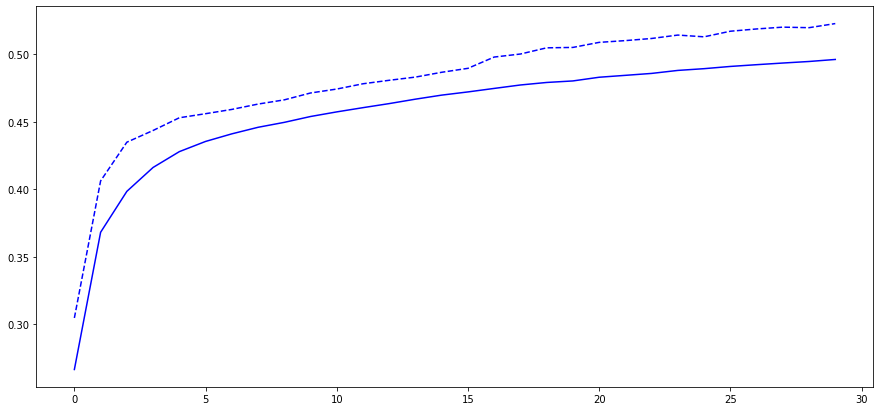

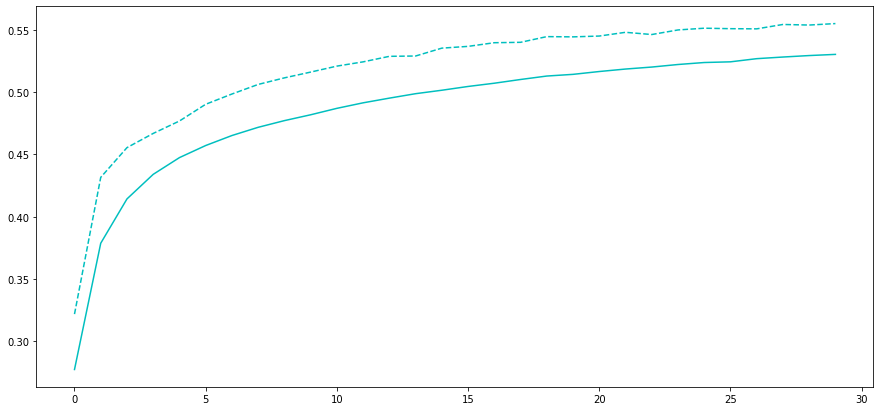

In [8]:

with open(os.path.join('/mnt/F0CC2854CC28177E/repos/workIRAFM/tensorflow-cmake/custom_op/results/mine_without_div','max_net_h.pkl'), 'rb') as f:
    max_net_h = pickle.load(f)
plt.figure(figsize=(15,7))
arr = np.array(max_net_h)
plt.plot(np.mean(arr[:,0], axis=0), 'r')
plt.plot(np.max(arr[:,0], axis=0), 'r--')

with open(os.path.join('/mnt/F0CC2854CC28177E/repos/workIRAFM/tensorflow-cmake/custom_op/results/mine_without_div','frac_net_h.pkl'), 'rb') as f:
    frac_net_h = pickle.load(f)
plt.figure(figsize=(15,7))
arr = np.array(frac_net_h)
plt.plot(np.mean(arr[:,0], axis=0), 'g')
plt.plot(np.max(arr[:,0], axis=0), 'g--')
with open(os.path.join('/mnt/F0CC2854CC28177E/repos/workIRAFM/tensorflow-cmake/custom_op/results/mine_without_div','ft_net_h.pkl'), 'rb') as f:
    ft_net_h = pickle.load(f)
plt.figure(figsize=(15,7))
arr = np.array(ft_net_h)
plt.plot(np.mean(arr[:,0], axis=0), 'b')
plt.plot(np.max(arr[:,0], axis=0), 'b--')
with open(os.path.join('/mnt/F0CC2854CC28177E/repos/workIRAFM/tensorflow-cmake/custom_op/results/mine_without_div','avg_net_h.pkl'), 'rb') as f:
    avg_net_h = pickle.load(f)
plt.figure(figsize=(15,7))
arr = np.array(avg_net_h)
plt.plot(np.mean(arr[:,0], axis=0), 'c')
plt.plot(np.max(arr[:,0], axis=0), 'c--')

(0,0.378) (1,0.421) (2,0.443) (3,0.459) (4,0.464) (5,0.474) (6,0.481) (7,0.481) (8,0.488) (9,0.491) (10,0.490) (11,0.491) (12,0.490) (13,0.499) (14,0.500) (15,0.497) (16,0.504) (17,0.506) (18,0.503) (19,0.505) (20,0.502) (21,0.510) (22,0.511) (23,0.514) (24,0.512) (25,0.513) (26,0.515) (27,0.514) (28,0.514) (29,0.514) 
(0,0.352) (1,0.403) (2,0.418) (3,0.429) (4,0.437) (5,0.444) (6,0.451) (7,0.452) (8,0.454) (9,0.460) (10,0.461) (11,0.467) (12,0.466) (13,0.471) (14,0.470) (15,0.471) (16,0.473) (17,0.476) (18,0.475) (19,0.476) (20,0.478) (21,0.479) (22,0.481) (23,0.482) (24,0.483) (25,0.483) (26,0.486) (27,0.484) (28,0.486) (29,0.488) 
(0,0.350) (1,0.390) (2,0.409) (3,0.420) (4,0.432) (5,0.438) (6,0.442) (7,0.447) (8,0.448) (9,0.454) (10,0.454) (11,0.458) (12,0.461) (13,0.462) (14,0.466) (15,0.465) (16,0.470) (17,0.471) (18,0.474) (19,0.475) (20,0.480) (21,0.480) (22,0.479) (23,0.481) (24,0.484) (25,0.484) (26,0.487) (27,0.486) (28,0.486) (29,0.490) 
(0,0.361) (1,0.398) (2,0.423) (3,0.44

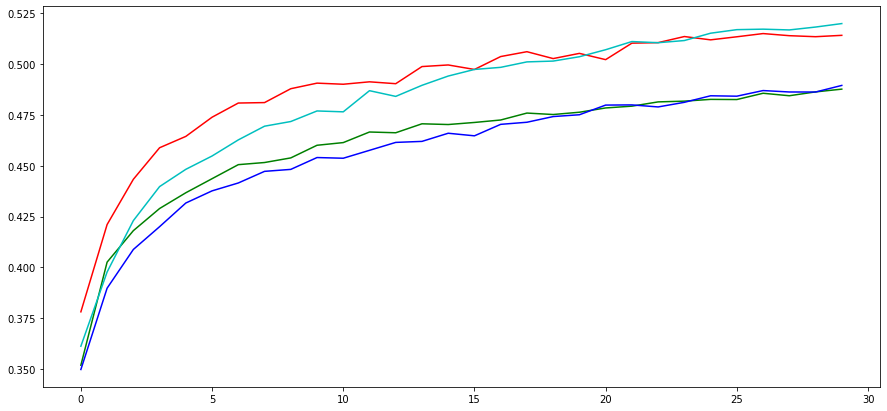

In [21]:
with open(os.path.join('/mnt/F0CC2854CC28177E/repos/workIRAFM/tensorflow-cmake/custom_op/results/mine_without_div','max_net_h.pkl'), 'rb') as f:
    max_net_h = pickle.load(f)
plt.figure(figsize=(15,7))
arr = np.array(max_net_h)
arr = np.mean(arr[:,1], axis=0)
plt.plot(arr, 'r')
for v in range(len(arr)):
  print("({},{:.3f})".format(v, arr[v]), end=' ')
print()

with open(os.path.join('/mnt/F0CC2854CC28177E/repos/workIRAFM/tensorflow-cmake/custom_op/results/mine_without_div','frac_net_h.pkl'), 'rb') as f:
    frac_net_h = pickle.load(f)
arr = np.array(frac_net_h)
arr = np.mean(arr[:,1], axis=0)
plt.plot(arr, 'g')
for v in range(len(arr)):
  print("({},{:.3f})".format(v, arr[v]), end=' ')
print()

with open(os.path.join('/mnt/F0CC2854CC28177E/repos/workIRAFM/tensorflow-cmake/custom_op/results/mine_without_div','ft_net_h.pkl'), 'rb') as f:
    ft_net_h = pickle.load(f)
arr = np.array(ft_net_h)
arr = np.mean(arr[:,1], axis=0)
plt.plot(arr, 'b')
for v in range(len(arr)):
  print("({},{:.3f})".format(v, arr[v]), end=' ')
print()

with open(os.path.join('/mnt/F0CC2854CC28177E/repos/workIRAFM/tensorflow-cmake/custom_op/results/mine_without_div','avg_net_h.pkl'), 'rb') as f:
    avg_net_h = pickle.load(f)
arr = np.array(avg_net_h)
arr = np.mean(arr[:,1], axis=0)
plt.plot(arr, 'c')
for v in range(len(arr)):
  print("({},{:.3f})".format(v, arr[v]), end=' ')
print()

In [3]:
ftpoolresnet = resnet.FtPoolingResnet(n=3)
ftpoolresnet.build_network()
ftpoolresnet.train()
ftpoolresnet.save_history('resnet')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
build build
Instructions for updating:
Colocations handled automatically by placer.
Using real-time data augmentation.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
1000/1000 [==============================] - 634s 634ms/step - loss: 1.5490 - accuracy: 0.5029 - val_loss: 1.8270 - val_accuracy: 0.4933
Epoch 2/200
1000/1000 [==============================] - 653s 653ms/step - loss: 1.1362 - accuracy: 0.6620 - val_loss: 1.2431 - val_accuracy: 0.6320
Epoch 3/200
1000/1000 [==============================] - 724s 724ms/step - loss: 0.9947 - accuracy: 0.7168 - val_loss: 1.1449 - val_accuracy: 0.6826
Epoch 4/200
1000/1000 [==============================] - 766s 766ms/step - loss: 0.9056 - accuracy: 0.7548 - val_loss: 1.0693 - val_accuracy: 0.7118
Epoch 5/200
1000/1000 [==============================] - 765s 765ms/step - loss: 0.8521 - accuracy: 0.7782 - val_loss: 0.9276 - val_accura

Epoch 51/200
1000/1000 [==============================] - 806s 806ms/step - loss: 0.6352 - accuracy: 0.9228 - val_loss: 0.8643 - val_accuracy: 0.8611
Epoch 52/200
1000/1000 [==============================] - 803s 803ms/step - loss: 0.6366 - accuracy: 0.9245 - val_loss: 0.9820 - val_accuracy: 0.8337
Epoch 53/200
1000/1000 [==============================] - 804s 804ms/step - loss: 0.6382 - accuracy: 0.9234 - val_loss: 0.9196 - val_accuracy: 0.8521
Epoch 54/200
1000/1000 [==============================] - 803s 803ms/step - loss: 0.6401 - accuracy: 0.9237 - val_loss: 0.9056 - val_accuracy: 0.8585
Epoch 55/200
1000/1000 [==============================] - 802s 802ms/step - loss: 0.6404 - accuracy: 0.9261 - val_loss: 0.9923 - val_accuracy: 0.8357
Epoch 56/200
1000/1000 [==============================] - 796s 796ms/step - loss: 0.6383 - accuracy: 0.9276 - val_loss: 1.0568 - val_accuracy: 0.8248
Epoch 57/200
1000/1000 [==============================] - 797s 797ms/step - loss: 0.6421 - accuracy:

1000/1000 [==============================] - 719s 719ms/step - loss: 0.4153 - accuracy: 0.9928 - val_loss: 0.8113 - val_accuracy: 0.9101
Epoch 160/200
1000/1000 [==============================] - 715s 715ms/step - loss: 0.4147 - accuracy: 0.9929 - val_loss: 0.8103 - val_accuracy: 0.9101
Epoch 161/200
1000/1000 [==============================] - 617s 617ms/step - loss: 0.4145 - accuracy: 0.9929 - val_loss: 0.8094 - val_accuracy: 0.9103
Epoch 162/200
1000/1000 [==============================] - 593s 593ms/step - loss: 0.4133 - accuracy: 0.9936 - val_loss: 0.8103 - val_accuracy: 0.9100
Epoch 163/200
1000/1000 [==============================] - 595s 595ms/step - loss: 0.4149 - accuracy: 0.9929 - val_loss: 0.8078 - val_accuracy: 0.9106
Epoch 164/200
1000/1000 [==============================] - 593s 593ms/step - loss: 0.4147 - accuracy: 0.9928 - val_loss: 0.8115 - val_accuracy: 0.9101
Epoch 165/200
1000/1000 [==============================] - 594s 594ms/step - loss: 0.4153 - accuracy: 0.9929

FileNotFoundError: [Errno 2] No such file or directory: 'resnet/FtPoolingResnet20.json'

In [5]:
for v in range(len(ftpoolresnet.history.history['val_accuracy'])):
  print("({},{:.3f})".format(v, ftpoolresnet.history.history['val_accuracy'][v]), end=' ')

(0,0.493) (1,0.632) (2,0.683) (3,0.712) (4,0.751) (5,0.761) (6,0.757) (7,0.780) (8,0.749) (9,0.763) (10,0.697) (11,0.785) (12,0.798) (13,0.819) (14,0.776) (15,0.832) (16,0.824) (17,0.815) (18,0.825) (19,0.712) (20,0.790) (21,0.816) (22,0.838) (23,0.824) (24,0.845) (25,0.854) (26,0.784) (27,0.848) (28,0.820) (29,0.840) (30,0.798) (31,0.828) (32,0.835) (33,0.822) (34,0.808) (35,0.814) (36,0.839) (37,0.846) (38,0.864) (39,0.831) (40,0.863) (41,0.816) (42,0.866) (43,0.827) (44,0.845) (45,0.850) (46,0.850) (47,0.827) (48,0.862) (49,0.832) (50,0.861) (51,0.834) (52,0.852) (53,0.859) (54,0.836) (55,0.825) (56,0.845) (57,0.847) (58,0.858) (59,0.824) (60,0.845) (61,0.869) (62,0.878) (63,0.863) (64,0.854) (65,0.850) (66,0.856) (67,0.853) (68,0.827) (69,0.865) (70,0.835) (71,0.841) (72,0.867) (73,0.870) (74,0.851) (75,0.870) (76,0.859) (77,0.876) (78,0.874) (79,0.852) (80,0.821) (81,0.902) (82,0.906) (83,0.908) (84,0.907) (85,0.905) (86,0.906) (87,0.905) (88,0.910) (89,0.910) (90,0.907) (91,0.909

In [9]:
with open("/mnt/F0CC2854CC28177E/repos/workIRAFM/lenetft/ftnet_with_permutations/history_jsons_8_kernels/resnet20.json") as f:
    data = json.load(f)

In [17]:
_sum = np.zeros(200, dtype=np.float32)
for s in data['val_accuracy']:
    _sum += np.array(s)
_sum /= 20

In [18]:
for v in range(len(_sum)):
  print("({},{:.3f})".format(v, _sum[v]), end=' ')

(0,0.495) (1,0.589) (2,0.629) (3,0.674) (4,0.698) (5,0.721) (6,0.708) (7,0.750) (8,0.748) (9,0.754) (10,0.765) (11,0.769) (12,0.779) (13,0.783) (14,0.789) (15,0.789) (16,0.785) (17,0.790) (18,0.786) (19,0.798) (20,0.804) (21,0.805) (22,0.821) (23,0.807) (24,0.814) (25,0.810) (26,0.812) (27,0.818) (28,0.821) (29,0.816) (30,0.817) (31,0.822) (32,0.820) (33,0.827) (34,0.826) (35,0.835) (36,0.822) (37,0.833) (38,0.831) (39,0.830) (40,0.825) (41,0.832) (42,0.832) (43,0.827) (44,0.836) (45,0.835) (46,0.832) (47,0.828) (48,0.826) (49,0.836) (50,0.844) (51,0.840) (52,0.836) (53,0.840) (54,0.836) (55,0.840) (56,0.836) (57,0.838) (58,0.838) (59,0.844) (60,0.834) (61,0.843) (62,0.835) (63,0.836) (64,0.838) (65,0.842) (66,0.836) (67,0.845) (68,0.839) (69,0.843) (70,0.840) (71,0.848) (72,0.848) (73,0.846) (74,0.855) (75,0.845) (76,0.839) (77,0.849) (78,0.843) (79,0.847) (80,0.840) (81,0.902) (82,0.904) (83,0.906) (84,0.907) (85,0.908) (86,0.908) (87,0.908) (88,0.909) (89,0.908) (90,0.908) (91,0.909